# Случайные процессы. Прикладной поток.
## Практическое задание 7

**Правила:**

* Выполненную работу нужно отправить на почту `probability.diht@yandex.ru`, указав тему письма `"[СП17] Фамилия Имя - Задание 7"`. Квадратные скобки обязательны, внутри них пробела быть не должно. Вместо `Фамилия Имя` нужно подставить свои фамилию и имя.
* Прислать нужно ноутбук и его pdf-версию. Названия файлов должны быть такими: `7.N.ipynb` и `7.N.pdf`, где `N` - ваш номер из таблицы с оценками.
* При проверке могут быть запущены функции, которые отвечают за генерацию траекторий винеровского процесса.

------------------

In [358]:
import numpy as np
import pandas as pd
from scipy.stats import norm
from scipy.stats import uniform
import matplotlib.pyplot as plt
%matplotlib inline

import re
from io import StringIO

from sklearn.metrics import mean_squared_error
from sklearn.linear_model import LinearRegression

import warnings
warnings.simplefilter('ignore')

## Регрессия на гауссовских процессах

Напомним задачу регрессии. Пусть имеется некоторая функциональная зависимость $y = f(x)$. Для ее оценки проводится серия испытаний в точках $x_1, ..., x_n$, в которых получаются значения $Y_i = f(x_i) + \varepsilon_i$, где $\varepsilon_i$ --- случайная ошибка измерений. Задача состоит в том, чтобы по этим наблюдениям оценить зависимость $f$. В курсе статистики мы рассматривали случай линейных функций. Теперь рассмотрим случай, когда $f$ является траекторией некоторого стационарного гауссовского процесса.

*Внимание!* Далее происходит смена обозначений на принятые в случайных процессах. Буква $x$ меняется на $t$, а буква $y$ меняется на $x$.

Пусть $X = (X_t, t \in \mathbb{R})$ --- стационарный гауссовский процесс с нулевой функцией среднего и ковариационной функцией $R(t) = cov(X_t, X_0)$. Даны его измерения $x_1, ..., x_n$ в моменты времени $t_1, ..., t_n$ соответственно. Тогда условное распределение $X_t$ при условии $X_{t_1} = x_1, ..., X_{t_n} = x_n$ является нормальным со средним $r^TC^{-1}\overrightarrow{x}$ и дисперсией $R(0) - r^TC^{-1}r$, где $C=\left(R(t_i - t_j)\right)_{i,j}$, $r=\left(R(t - t_1), ..., R(t - t_n)\right)^T$, $\overrightarrow{x}=\left(x_1, ..., x_n\right)^T$.


Байесовской оценкой общего вида значения процесса в момент времени $t$ является условное распределение $X_t$ при условии $...$.
В качестве точечной оценки обычно берут условное математическое ожидание $\mathsf{E}\left(X_t \left| X_{t_1} = x_1,\ ...,\ X_{t_n} = x_n \right. \right)$.
Кроме того, для каждого $t$ можно построить доверительный интервал для величины $X_t$, зная условную дисперсию.

Предположим, что для каждого $t$ построен доверительный интервал для $X_t$ уровня доверия 0.95. Верно ли, что $\mathsf{P}(\exists t: \text{истинное значение $X_t$ не попало в свой доверительный интервал}) \leqslant 0.05$?

Нет, естли построен доверительный интервал для $X_t$, это означает что вероятность попадания $X_t$ в него равна $0.95$, а не попадания соответственно $0.05$. Тогда $\mathsf{P}(\exists t: \text{истинное значение $X_t$ не попало в свой доверительный интервал}) = 1 - \mathsf{P}(\forall t: \text{истинное значение $X_t$ попало в свой доверительный интервал}) \to 1$

Напишите класс регрессии на гауссовских процессах.
Интерфейс похож на интерфейс библиотеки `scikit-learn`.

Наш класс будет работать для времени из $\mathbb{R}^d$, а не $\mathbb{R}$.
Почему так можно сделать на основе решенной задачи?

Координаты независимы

При написании класса пользуйтесь `numpy.matrix` для работы с матрицами, либо операцией `@` для объектов `numpy.array`.

In [2]:
class GaussianProcessRegression:
    
    def __init__(self, cov_function):
        self.cov_function = cov_function
    
    
    def fit(self, T, X):
        ''' "Обучение" модели регрессии.
                T --- np.array, размерность (n, d): моменты времени, 
                      в которые проведены измерения
                X --- np.array, размерность n: полученные значения процесса
        '''
        self.fit_times = T
        
        x = np.tile(T, (len(T), 1, 1))
        y = np.transpose(x, (1, 0, 2))
        self.inv_c = self.cov_function(x - y)
        self.inv_c = np.linalg.inv(self.inv_c)
        
        self.mean_coeff = self.inv_c @ X
        
        return self
        
        
    def predict(self, T):
        ''' Оценка значения процесса. 
                T --- np.array, размерность (n, d): моменты времени, 
                      в которые нужно оценить значения. 
                
            Возвращает:
                values --- np.array, размерность n: предсказанные 
                           значения процесса
                sigma --- np.array, размерность n: соответствующая дисперсия
        '''
        
        r = self.cov_function(np.tile(np.transpose([T], (1, 0, 2)), 
                                      (len(self.fit_times), 1))\
                                       - self.fit_times)
        values = r @ self.mean_coeff
        sigma  = self.cov_function(np.zeros_like(T[0]))\
                 - np.sum(r @ self.inv_c * r, axis=1)
        
        return values, sigma 
               

Зададим какую-нибудь простую функцию $f(t)$

In [4]:
def calc_f(t, a=0.2, b=0.5, c=2):
    return np.log(1 + t) + a * t + b * np.sin(c * t)

И ковариационную функцию
$$R(t) = a\ exp\left(\frac{\left|\left| t \right|\right|^2} {2s^2} \right),$$

* $t \in \mathbb{R}^d$
* $a, s > 0$ --- параметры

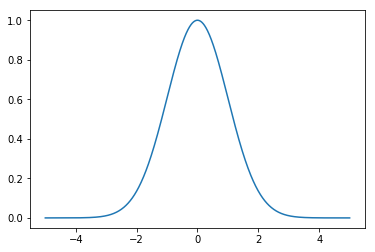

In [7]:
def exp_cov(t, a=1, s=1):
    return a * np.exp(-(t ** 2).sum(axis=-1) / (2 * s ** 2))

grid = np.linspace(-5, 5, 1001)
plt.figure(figsize=(6, 4))
plt.plot(grid, exp_cov(grid.reshape((-1, 1))))
plt.show()

Проведем эксперименты.
Зададим гауссовский процесс $(X_t, t\in\mathbb{R})$ в виде $X_t = f(t) + \sigma\varepsilon_t$, где $(\varepsilon_t, t\in\mathbb{R})$ --- гауссовский белый шум, то есть все $\varepsilon_t$ независимы и имеют стандартное нормальное распределение.

В качестве моментов времени $t_1, ..., t_n$ гененируем несколько точек на прямой.
Для начала возьмем $\sigma=0$, что соответствует отсутствию погрешности измерений.
Выполните код ниже.

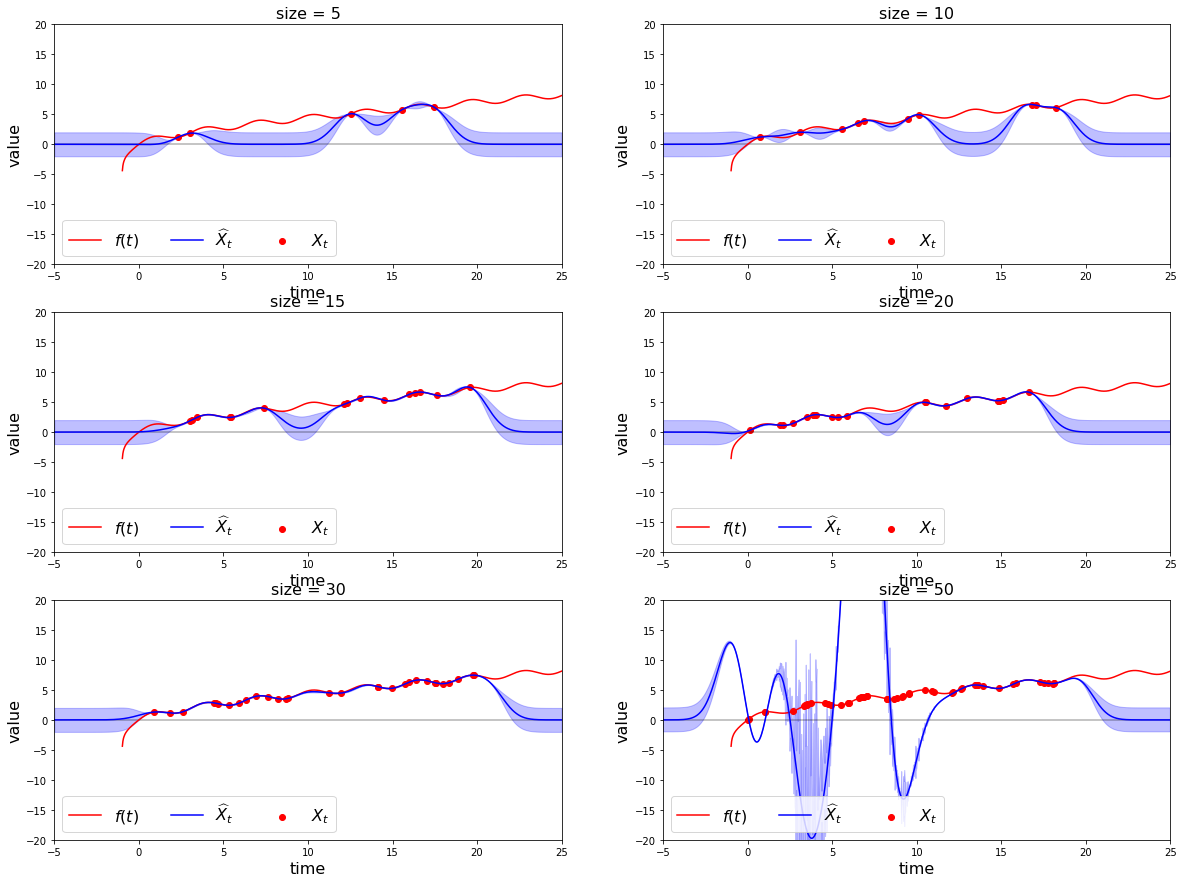

In [115]:
plt.figure(figsize=(20, 15))

# size --- количество наблюдаемых данных
for i, size in enumerate([5, 10, 15, 20, 30, 50]):

    # Генерация данных
    T = uniform(loc=0, scale=20).rvs(size=size)
    X = calc_f(T)
    
    # Сначала выполните код в этой ячейке с закомментированной строчкой кода.
    # Затем скопируйте код в новую ячейку, раскомментируйте строчку и выполните код.
    # X += norm(0, 0.3).rvs(X.shape)
    
    # Применение регрессии
    gpr = GaussianProcessRegression(exp_cov).fit(T.reshape((-1, 1)), X)
    grid = np.linspace(-5, 25, 1000).reshape((-1, 1))
    predict, sigma = gpr.predict(grid)
    grid, predict, sigma = np.array(grid).ravel(), predict, sigma

    # Построение графиков
    plt.subplot(3, 2, i + 1)
    plt.plot(grid, calc_f(grid), color='red', label='$f(t)$')
    plt.plot(grid, predict, color='blue', label='$\widehat{X}_t$')
    plt.fill_between(grid, predict + 2 * sigma, predict - 2 * sigma, 
                     color='blue', alpha=0.25)
    plt.scatter(T, X, color='red', label='$X_t$')
    plt.hlines(0, -5, 25, alpha=0.3)
    plt.xlim((-5, 25))
    plt.ylim((-20, 20))
    plt.title('size = {}'.format(size), fontsize=16)
    plt.xlabel('time', fontsize=16)
    plt.ylabel('value', fontsize=16)
    plt.legend(loc=3, ncol=3, fontsize=16)

plt.show()

Теперь предположим, что измерения проводятся с погрешностью, то есть $\sigma > 0$. Скопируйте код выше в новую ячейку, раскомментируйте строчку кода и запустите.

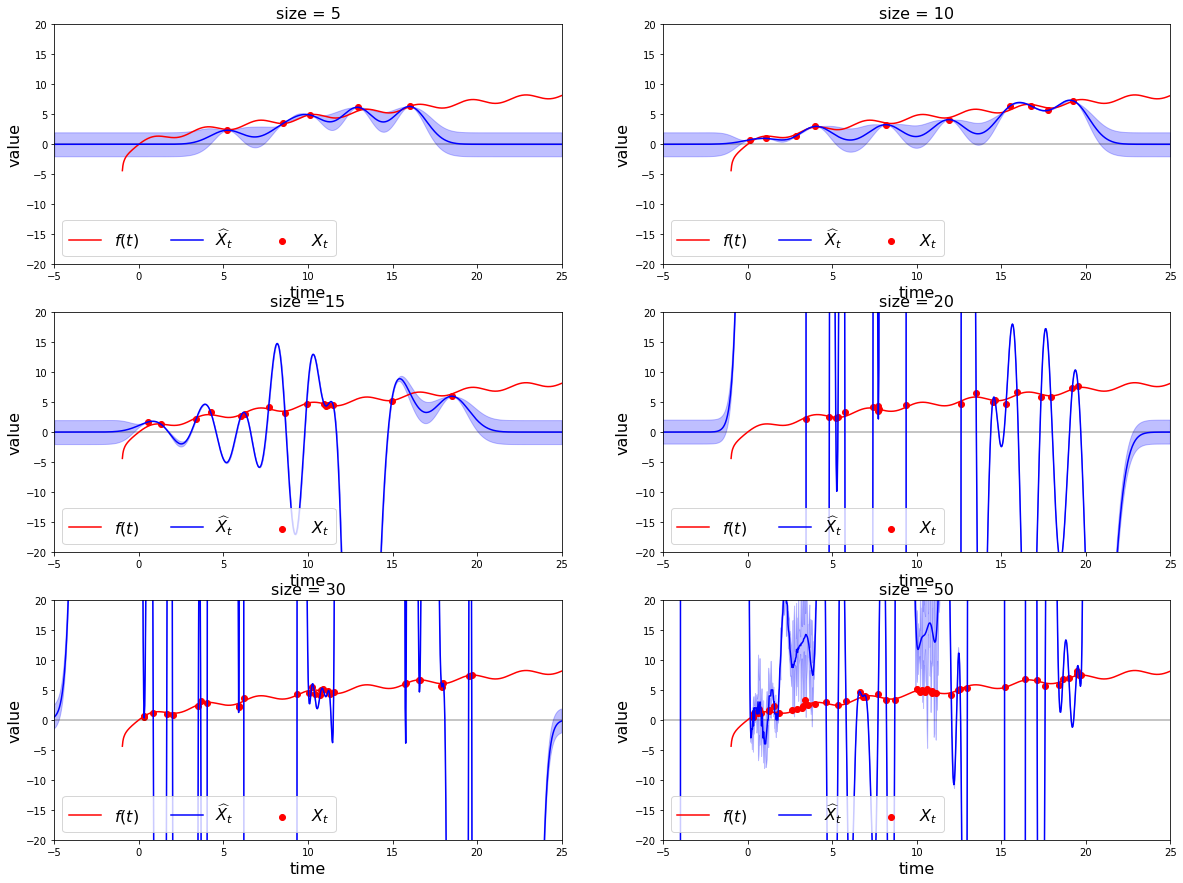

In [74]:
plt.figure(figsize=(20, 15))

# size --- количество наблюдаемых данных
for i, size in enumerate([5, 10, 15, 20, 30, 50]):

    # Генерация данных
    T = uniform(loc=0, scale=20).rvs(size=size)
    X = calc_f(T)
    
    # Сначала выполните код в этой ячейке с закомментированной строчкой кода.
    # Затем скопируйте код в новую ячейку, раскомментируйте строчку и выполните код.
    X += norm(0, 0.3).rvs(X.shape)

    # Применение регрессии
    gpr = GaussianProcessRegression(exp_cov).fit(T.reshape((-1, 1)), X)
    grid = np.linspace(-5, 25, 1000).reshape((-1, 1))
    predict, sigma = gpr.predict(grid)
    grid, predict, sigma = np.array(grid).ravel(), predict, sigma

    # Построение графиков
    plt.subplot(3, 2, i + 1)
    plt.plot(grid, calc_f(grid), color='red', label='$f(t)$')
    plt.plot(grid, predict, color='blue', label='$\widehat{X}_t$')
    plt.fill_between(grid, predict + 2 * sigma, predict - 2 * sigma, 
                     color='blue', alpha=0.25)
    plt.scatter(T, X, color='red', label='$X_t$')
    plt.hlines(0, -5, 25, alpha=0.3)
    plt.xlim((-5, 25))
    plt.ylim((-20, 20))
    plt.title('size = {}'.format(size), fontsize=16)
    plt.xlabel('time', fontsize=16)
    plt.ylabel('value', fontsize=16)
    plt.legend(loc=3, ncol=3, fontsize=16)

plt.show()

Почему получается так плохо? Что нужно сделать, чтобы это исправить (обратите внимание на ковариационную функцию)?

Необходимо добавить $\sigma^2\delta\left({X, X_0}\right)$, поскольку $\delta\left({X, X_0}\right)$ прибавить не получится, можно приблизить линиями

Исправьте это.

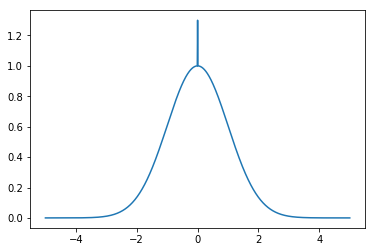

In [335]:
def exp_cov(t, a=1, s=1):
    len_t = (t ** 2).sum(axis=-1)
    
    delta = np.zeros_like(len_t, dtype=np.float64)
    small = len_t < 10e-12
    delta[small] = -np.abs(10**12 * len_t[small]) + 1
    
    return a * np.exp(-len_t / (2 * s ** 2)) + 0.3 * delta

grid = np.linspace(-5, 5, 1001)
plt.figure(figsize=(6, 4))
plt.plot(grid, exp_cov(grid.reshape((-1, 1))))
plt.show()

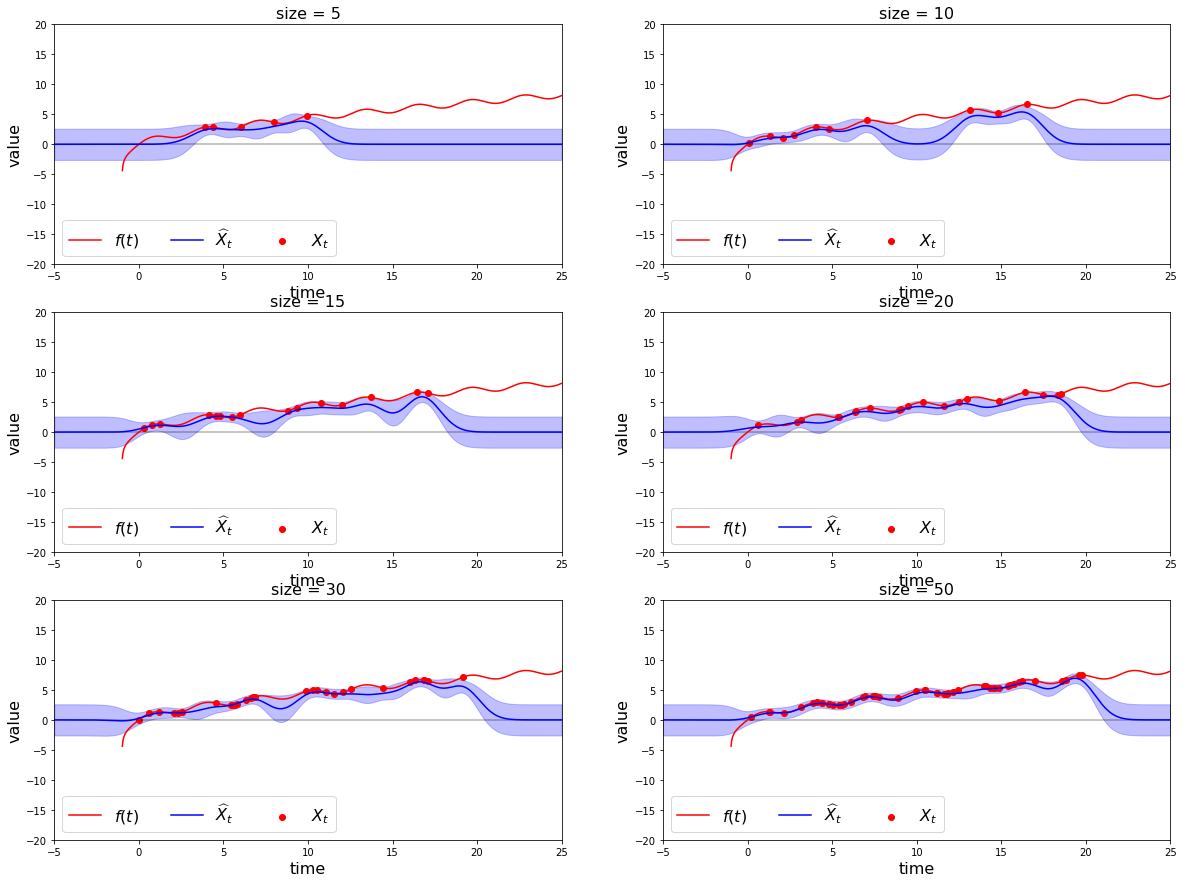

In [336]:
plt.figure(figsize=(20, 15))

# size --- количество наблюдаемых данных
for i, size in enumerate([5, 10, 15, 20, 30, 50]):

    # Генерация данных
    T = uniform(loc=0, scale=20).rvs(size=size)
    X = calc_f(T)
    
    # Сначала выполните код в этой ячейке с закомментированной строчкой кода.
    # Затем скопируйте код в новую ячейку, раскомментируйте строчку и выполните код.
    # X += norm(0, 0.3).rvs(X.shape)
    
    # Применение регрессии
    gpr = GaussianProcessRegression(exp_cov).fit(T.reshape((-1, 1)), X)
    grid = np.linspace(-5, 25, 1000).reshape((-1, 1))
    predict, sigma = gpr.predict(grid)
    grid, predict, sigma = np.array(grid).ravel(), predict, sigma

    # Построение графиков
    plt.subplot(3, 2, i + 1)
    plt.plot(grid, calc_f(grid), color='red', label='$f(t)$')
    plt.plot(grid, predict, color='blue', label='$\widehat{X}_t$')
    plt.fill_between(grid, predict + 2 * sigma, predict - 2 * sigma, 
                     color='blue', alpha=0.25)
    plt.scatter(T, X, color='red', label='$X_t$')
    plt.hlines(0, -5, 25, alpha=0.3)
    plt.xlim((-5, 25))
    plt.ylim((-20, 20))
    plt.title('size = {}'.format(size), fontsize=16)
    plt.xlabel('time', fontsize=16)
    plt.ylabel('value', fontsize=16)
    plt.legend(loc=3, ncol=3, fontsize=16)

plt.show()

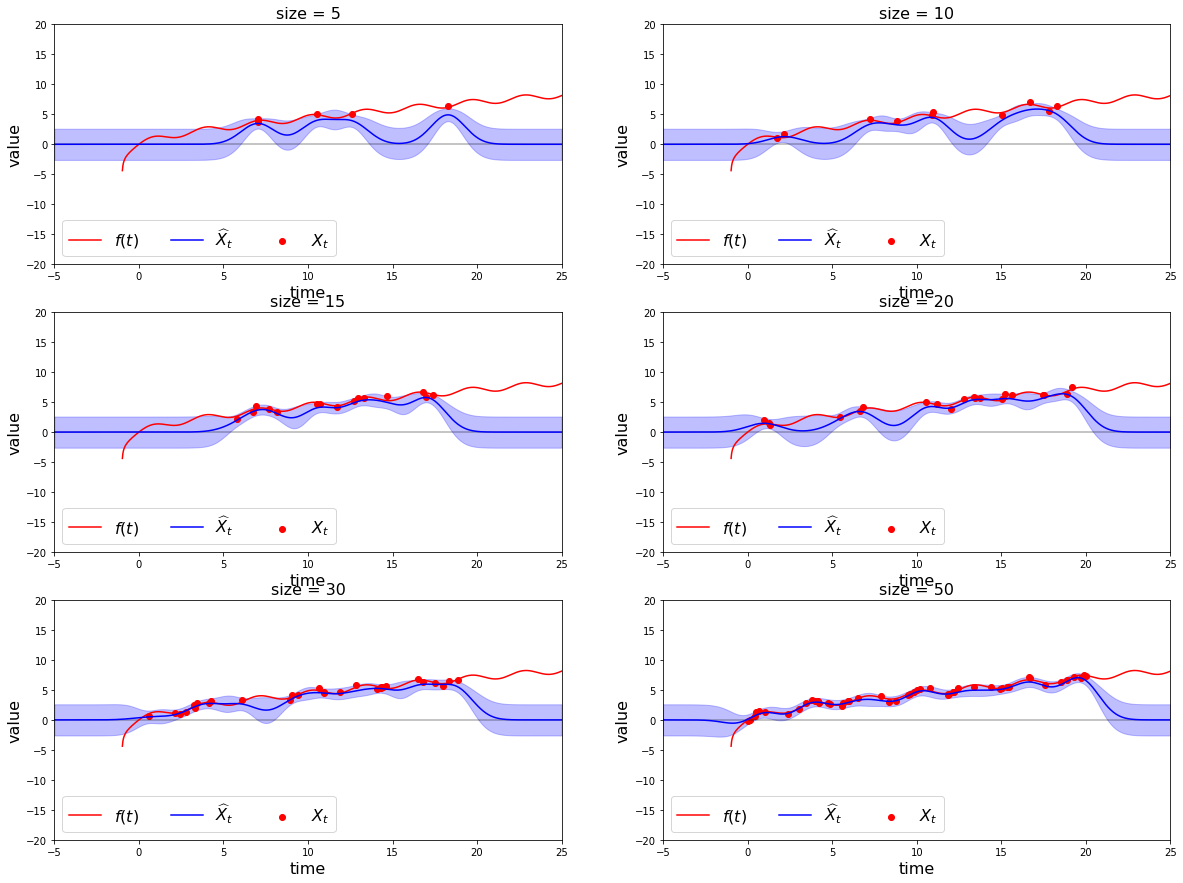

In [337]:
plt.figure(figsize=(20, 15))

# size --- количество наблюдаемых данных
for i, size in enumerate([5, 10, 15, 20, 30, 50]):

    # Генерация данных
    T = uniform(loc=0, scale=20).rvs(size=size)
    X = calc_f(T)
    
    # Сначала выполните код в этой ячейке с закомментированной строчкой кода.
    # Затем скопируйте код в новую ячейку, раскомментируйте строчку и выполните код.
    X += norm(0, 0.3).rvs(X.shape)

    # Применение регрессии
    gpr = GaussianProcessRegression(exp_cov).fit(T.reshape((-1, 1)), X)
    grid = np.linspace(-5, 25, 1000).reshape((-1, 1))
    predict, sigma = gpr.predict(grid)
    grid, predict, sigma = np.array(grid).ravel(), predict, sigma

    # Построение графиков
    plt.subplot(3, 2, i + 1)
    plt.plot(grid, calc_f(grid), color='red', label='$f(t)$')
    plt.plot(grid, predict, color='blue', label='$\widehat{X}_t$')
    plt.fill_between(grid, predict + 2 * sigma, predict - 2 * sigma, 
                     color='blue', alpha=0.25)
    plt.scatter(T, X, color='red', label='$X_t$')
    plt.hlines(0, -5, 25, alpha=0.3)
    plt.xlim((-5, 25))
    plt.ylim((-20, 20))
    plt.title('size = {}'.format(size), fontsize=16)
    plt.xlabel('time', fontsize=16)
    plt.ylabel('value', fontsize=16)
    plt.legend(loc=3, ncol=3, fontsize=16)

plt.show()

Почему стало лучше?

При первом варианте не верно считалась кореляция между величинами, когда мы это поправили все встало на свои места

Однако, это все равно не поясняет, почему в самом первом случае (при $\sigma=0$) мог наблюдаться похожий эффект. В чем его причина?

Когда в тестовую выборку попадались близко стоящие значения

Пойдем теперь дальше. Вспомним наше предположение о том, что математическое ожидание равно нулю, хотя на самом деле это не так.
Давайте это исправим.
В примере выше перед применением регрессии вычтете среднее значение, а после --- добавьте обратно.

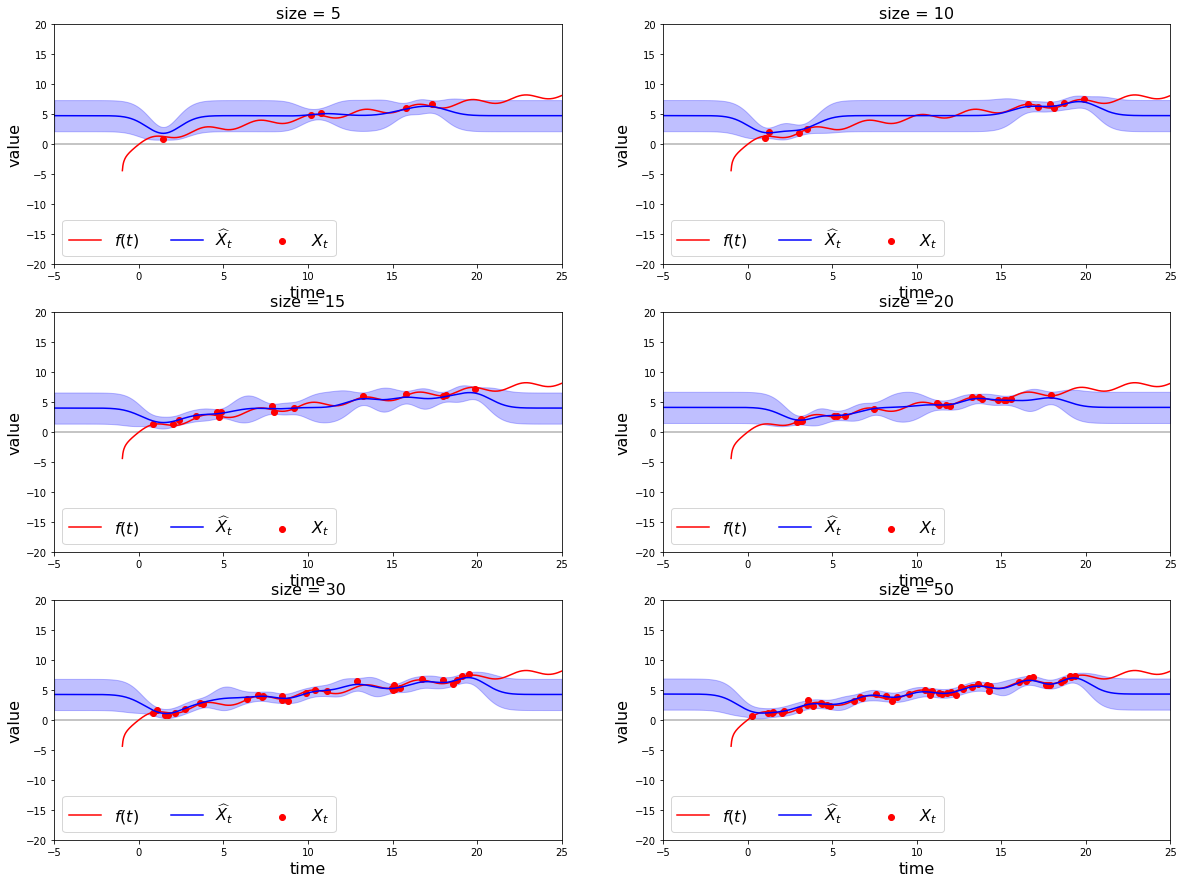

In [338]:
plt.figure(figsize=(20, 15))

# size --- количество наблюдаемых данных
for i, size in enumerate([5, 10, 15, 20, 30, 50]):

    # Генерация данных
    T = uniform(loc=0, scale=20).rvs(size=size)
    X = calc_f(T)
    
    # Сначала выполните код в этой ячейке с закомментированной строчкой кода.
    # Затем скопируйте код в новую ячейку, раскомментируйте строчку и выполните код.
    X += norm(0, 0.3).rvs(X.shape)
    
    mean = np.mean(X)

    # Применение регрессии
    gpr = GaussianProcessRegression(exp_cov).fit(T.reshape((-1, 1)), X - mean)
    grid = np.linspace(-5, 25, 1000).reshape((-1, 1))
    predict, sigma = gpr.predict(grid)
    grid, predict, sigma = np.array(grid).ravel(), predict + mean, sigma

    # Построение графиков
    plt.subplot(3, 2, i + 1)
    plt.plot(grid, calc_f(grid), color='red', label='$f(t)$')
    plt.plot(grid, predict, color='blue', label='$\widehat{X}_t$')
    plt.fill_between(grid, predict + 2 * sigma, predict - 2 * sigma, 
                     color='blue', alpha=0.25)
    plt.scatter(T, X, color='red', label='$X_t$')
    plt.hlines(0, -5, 25, alpha=0.3)
    plt.xlim((-5, 25))
    plt.ylim((-20, 20))
    plt.title('size = {}'.format(size), fontsize=16)
    plt.xlabel('time', fontsize=16)
    plt.ylabel('value', fontsize=16)
    plt.legend(loc=3, ncol=3, fontsize=16)

plt.show()

Лучше, но все равно чего-то не хватает.
Может, приблизить линейной регрессией?

Проделайте аналогичные действия, построив сначала линейную регрессию, затем вычев ее значения из точек данных перед применением регрессии на гауссовских процессах, а после --- добавив обратно значения линейной регрессии для всех точек, в которых вы хотите построить предсказания.

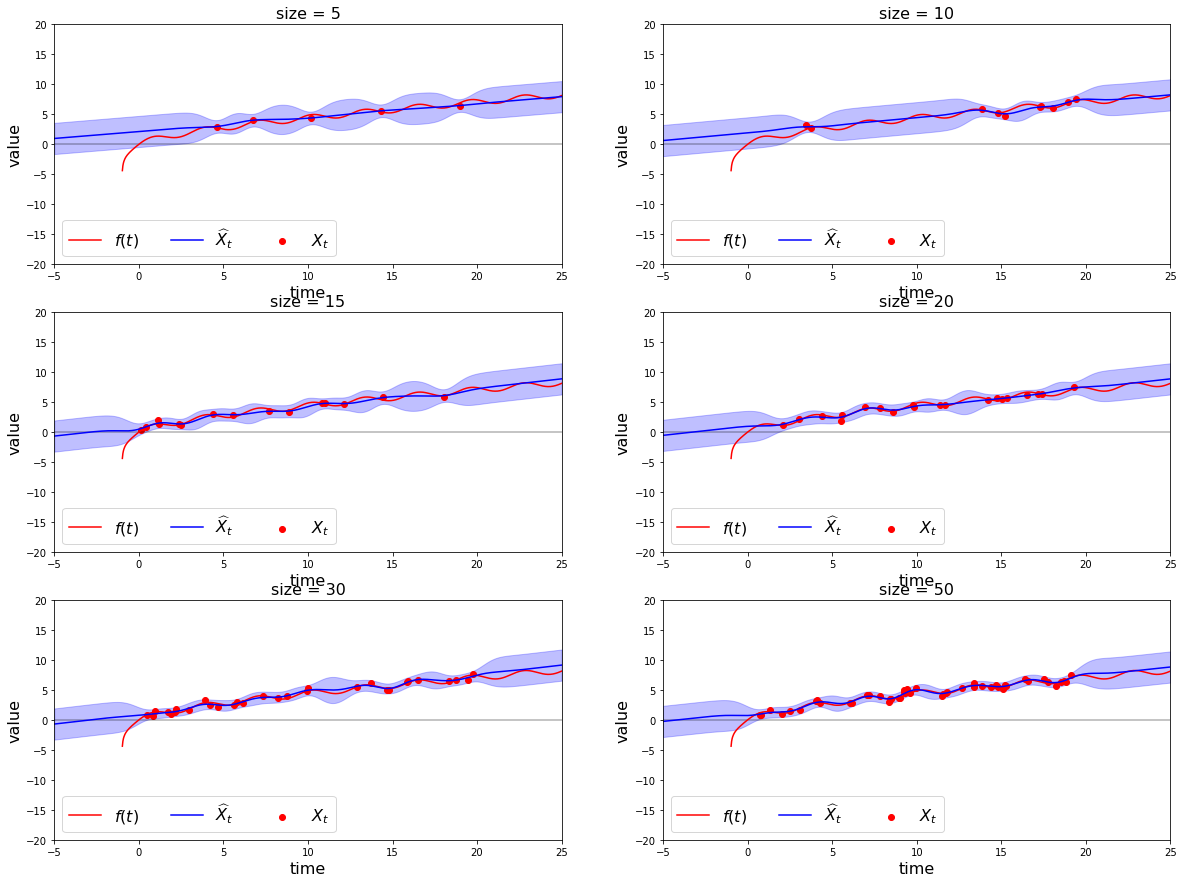

In [339]:
plt.figure(figsize=(20, 15))

# size --- количество наблюдаемых данных
for i, size in enumerate([5, 10, 15, 20, 30, 50]):

    # Генерация данных
    T = uniform(loc=0, scale=20).rvs(size=size)
    X = calc_f(T)
    
    # Сначала выполните код в этой ячейке с закомментированной строчкой кода.
    # Затем скопируйте код в новую ячейку, раскомментируйте строчку и выполните код.
    X += norm(0, 0.3).rvs(X.shape)
    
    LR = LinearRegression()
    LR.fit(list(zip(np.ones_like(T), T)), X)

    # Применение регрессии
    gpr = GaussianProcessRegression(exp_cov).fit(T.reshape((-1, 1)), X - LR.predict(list(zip(np.ones_like(T), T))))
    grid = np.linspace(-5, 25, 1000).reshape((-1, 1))
    predict, sigma = gpr.predict(grid)
    grid, predict, sigma = np.array(grid).ravel(), predict, sigma
    predict += LR.predict(list(zip(np.ones_like(grid), grid)))

    # Построение графиков
    plt.subplot(3, 2, i + 1)
    plt.plot(grid, calc_f(grid), color='red', label='$f(t)$')
    plt.plot(grid, predict, color='blue', label='$\widehat{X}_t$')
    plt.fill_between(grid, predict + 2 * sigma, predict - 2 * sigma, 
                     color='blue', alpha=0.25)
    plt.scatter(T, X, color='red', label='$X_t$')
    plt.hlines(0, -5, 25, alpha=0.3)
    plt.xlim((-5, 25))
    plt.ylim((-20, 20))
    plt.title('size = {}'.format(size), fontsize=16)
    plt.xlabel('time', fontsize=16)
    plt.ylabel('value', fontsize=16)
    plt.legend(loc=3, ncol=3, fontsize=16)

plt.show()

Разберемся подробнее в том, что происходит.

Допустим, мы хотим приблизить простую линейную функцию.
Построим график выборки и график предсказаний с помощью линейной регрессии.
Построим так же график ошибок, то есть точек $X_{t_i} - \widehat{f}(t_i)$, где $\widehat{f}$ --- линейная регрессия.

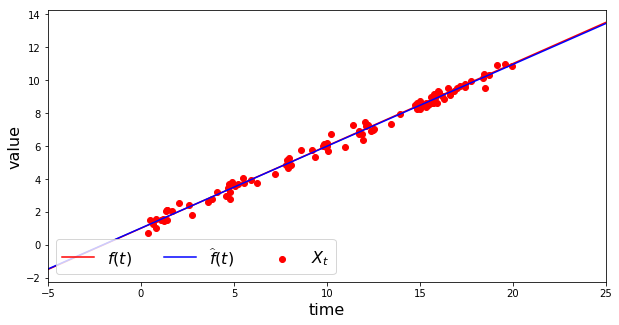

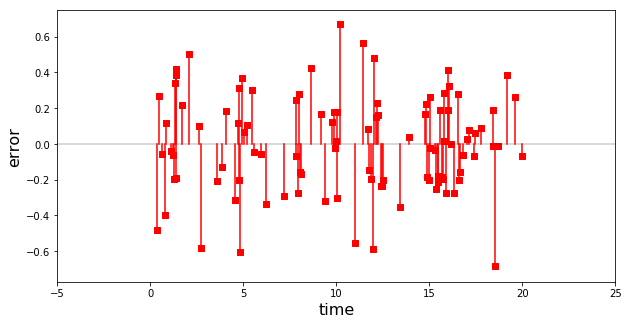

In [340]:
def f_lin(x):
    return x / 2 + 1

T = uniform(loc=0, scale=20).rvs(size=100).reshape((-1, 1))
X = f_lin(T)
X += norm(0, 0.3).rvs(X.shape)

LR = LinearRegression()
LR.fit(list(zip(np.ones_like(T.ravel()), T.ravel())), X.ravel())

grid = np.linspace(-5, 25, 1000).reshape((-1, 1))
predict = LR.predict(list(zip(np.ones_like(grid.ravel()), grid.ravel())))

# График выборки и линейной регресии
plt.figure(figsize=(10, 5))
plt.plot(grid, f_lin(grid), color='red', label='$f(t)$')
plt.plot(grid, predict, color='blue', label='$\widehat{f}(t)$')
plt.scatter(T, X, color='red', label='$X_t$')
plt.xlim((-5, 25))
plt.xlabel('time', fontsize=16)
plt.ylabel('value', fontsize=16)
plt.legend(loc=3, ncol=3, fontsize=16)
plt.show()

# График ошибок
plt.figure(figsize=(10, 5))
for i in range(len(T)):
    plt.plot([T[i], T[i]], [0, X[i] - LR.predict([1, T[i]])], color='red')
    plt.scatter(T[i], X[i] - LR.predict([1, T[i]]), marker='s', color='red')
plt.hlines(0, -5, 25, alpha=0.2)
plt.xlim((-5, 25))
plt.xlabel('time', fontsize=16)
plt.ylabel('error', fontsize=16)
plt.show()

Что можно сказать про остатки?

Они распределены относительно проямой равномерно

Теперь посмотрим на функцию, с которой мы имели дело ранее.

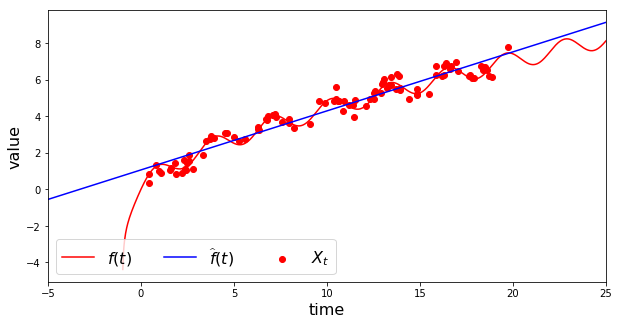

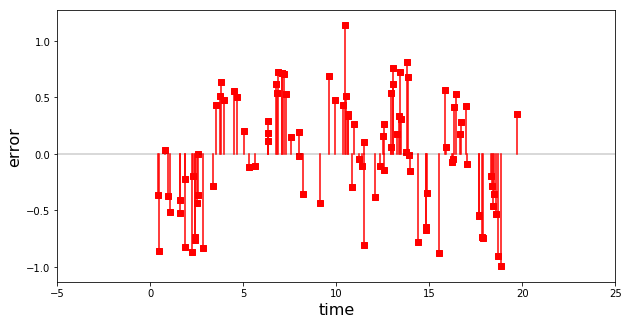

In [341]:
T = uniform(loc=0, scale=20).rvs(size=100).reshape((-1, 1))
X = calc_f(T)
X += norm(0, 0.3).rvs(X.shape)

LR = LinearRegression()
LR.fit(list(zip(np.ones_like(T.ravel()), T.ravel())), X.ravel())

grid = np.linspace(-5, 25, 1000).reshape((-1, 1))
predict = LR.predict(list(zip(np.ones_like(grid.ravel()), grid.ravel())))

# График выборки и линейной регресии
plt.figure(figsize=(10, 5))
plt.plot(grid, calc_f(grid), color='red', label='$f(t)$')
plt.plot(grid, predict, color='blue', label='$\widehat{f}(t)$')
plt.scatter(T, X, color='red', label='$X_t$')
plt.xlim((-5, 25))
plt.xlabel('time', fontsize=16)
plt.ylabel('value', fontsize=16)
plt.legend(loc=3, ncol=3, fontsize=16)
plt.show()

# График ошибок
plt.figure(figsize=(10, 5))
for i in range(len(T)):
    plt.plot([T[i], T[i]], [0, X[i] - LR.predict([1, T[i]])], color='red')
    plt.scatter(T[i], X[i] - LR.predict([1, T[i]]), marker='s', color='red')
plt.hlines(0, -5, 25, alpha=0.2)
plt.xlim((-5, 25))
plt.xlabel('time', fontsize=16)
plt.ylabel('error', fontsize=16)
plt.show()

Что тут с остатками?

А в этом случае распределены переодически

Давайте приближать эту зависимость в остатках регрессией на основе гауссовских процессах.

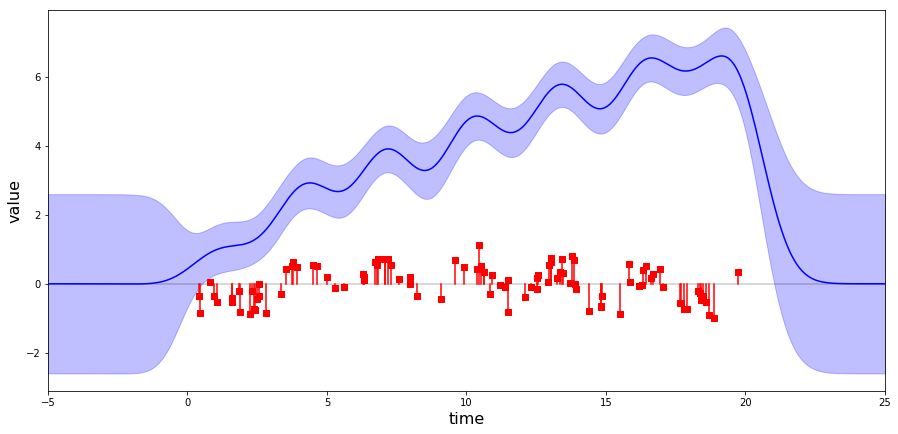

In [342]:
gpr = GaussianProcessRegression(exp_cov).fit(T.reshape((-1, 1)), X)
grid = np.linspace(-5, 25, 1000).reshape((-1, 1))
predict, sigma = gpr.predict(grid)
grid, predict, sigma = np.array(grid).ravel(), predict.ravel(), sigma.ravel()

plt.figure(figsize=(15, 7))
plt.plot(grid, predict, color='blue')
plt.fill_between(grid, predict + 2 * sigma, predict - 2 * sigma, 
                 color='blue', alpha=0.25)
for i in range(len(T)):
    plt.plot([T[i], T[i]], [0, X[i] - LR.predict([1, T[i]])], color='red')
    plt.scatter(T[i], X[i] - LR.predict([1, T[i]]), marker='s', color='red')
plt.hlines(0, -5, 25, alpha=0.2)
plt.xlim((-5, 25))
plt.xlabel('time', fontsize=16)
plt.ylabel('value', fontsize=16)
plt.show()

Сделайте подробные выводы.

При помощи гауссовской регрессии можно приближать не линейные функции с их ошибкой не зная самой зависимости зависимости, также как оказалось бывает полезным для начала приблизить линейной регрессией, а затем уже приближать остатки.

Рассмотрим теперь гауссовский процесс $(X_t, t\in\mathbb{R}_+)$, заданный как $X_t = t + W_{t+1} - W_{t}$, где $(W_t, t\in\mathbb{R}_+)$ --- винеровский процесс.
Сгенерируйте данные в соответствии с этой моделью. Для генерации винеровского процесса используйте код из предыдущего задания. По этим данным постройте комбинацию линейная регрессия + регрессия на гауссовских процессах, как в примерах выше. Как и раньше, проведите эксперимент для различного объема данных.

In [343]:
class WinerProcess:
    def __init__(self, precision=10000):
        self.n = precision
        self.xi = []
        self.start = []
        self.end = []
        self.ns = np.linspace(0, 
                              int(np.log(precision)) + 1,
                              int(np.log(precision)) + 2)
        self.midval = 2 ** (-self.ns / 2 - 1)
        self.lens = 2 ** (-self.ns - 1)
        
    def _add_one(self):
        if len(self.xi):
            start = self.end[-1]
        else:
            start = 0
        self.xi += [np.array(norm.rvs(size=self.n))]
        self.start += [start]
        self.end += [start + self.xi[-1][0]]
            
    def _create(self, t):
        while len(self.xi) < t + 1:
            self._add_one()
    
    def _get(self, xi, t):
        ks = (2 ** self.ns * (t + 1)).astype(int)
        aa = 2**(-self.ns) * ks - 1
        mid = aa + 2 ** (-self.ns - 1)
        ans = np.zeros(len(mid))
        ans[t < mid] = self.midval[t < mid] * \
                       (t - aa[t < mid])
        ans[t >= mid] = self.midval[t>=mid] *       \
                        (1 - (t - mid[t >= mid]) /  \
                         self.lens[t>=mid])
        
        while (ks[-1] >= self.n):
            ks = ks[:-1]
            ans = ans[:-1]
        res = t * xi[0] + (xi[ks] * ans).sum()
        return res
        
    
    def __getitem__(self, times):
        if type(times) is float:
            times = [times]
        times = np.array(times)
        seg = times.astype(int)
        self._create(seg.max())
        return [self.start[int(times[i])] + \
                self._get(self.xi[int(times[i])], times[i] - \
                          int(times[i])) \
                for i in range(len(times))]

In [344]:
def get_f(winer_process, t):
    return t + winer_process[t + 1] - winer_process[t]

In [345]:
winer_process = WinerProcess()

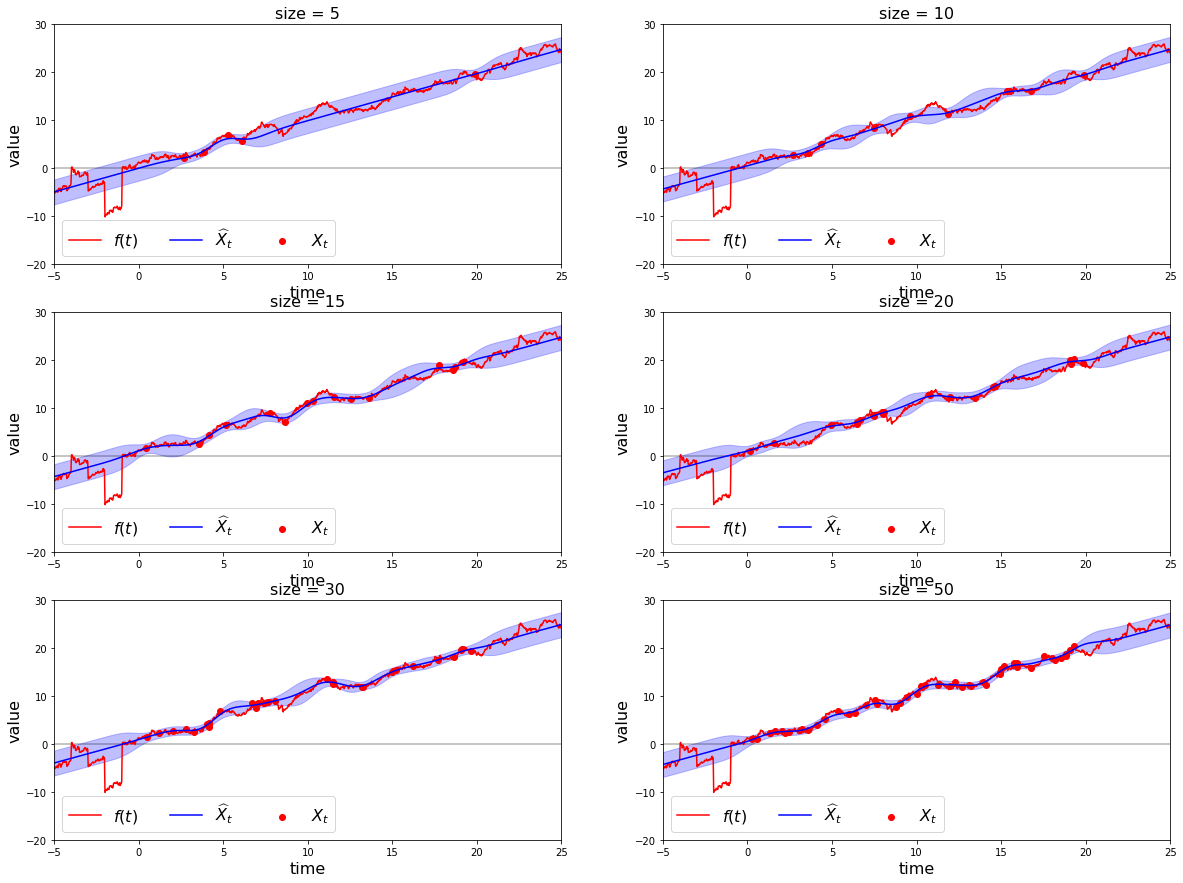

In [346]:
plt.figure(figsize=(20, 15))

# size --- количество наблюдаемых данных
for i, size in enumerate([5, 10, 15, 20, 30, 50]):

    # Генерация данных
    T = uniform(loc=0, scale=20).rvs(size=size)
    X = get_f(winer_process, T)
    
    # Сначала выполните код в этой ячейке с закомментированной строчкой кода.
    # Затем скопируйте код в новую ячейку, раскомментируйте строчку и выполните код.
    X += norm(0, 0.3).rvs(X.shape)
    
    LR = LinearRegression()
    LR.fit(list(zip(np.ones_like(T), T)), X)

    # Применение регрессии
    gpr = GaussianProcessRegression(exp_cov).fit(T.reshape((-1, 1)), X - LR.predict(list(zip(np.ones_like(T), T))))
    grid = np.linspace(-5, 25, 1000).reshape((-1, 1))
    predict, sigma = gpr.predict(grid)
    grid, predict, sigma = np.array(grid).ravel(), predict, sigma
    predict += LR.predict(list(zip(np.ones_like(grid), grid)))

    # Построение графиков
    plt.subplot(3, 2, i + 1)
    plt.plot(grid, get_f(winer_process, grid), color='red', label='$f(t)$')
    plt.plot(grid, predict, color='blue', label='$\widehat{X}_t$')
    plt.fill_between(grid, predict + 2 * sigma, predict - 2 * sigma, 
                     color='blue', alpha=0.25)
    plt.scatter(T, X, color='red', label='$X_t$')
    plt.hlines(0, -5, 30, alpha=0.3)
    plt.xlim((-5, 25))
    plt.ylim((-20, 30))
    plt.title('size = {}'.format(size), fontsize=16)
    plt.xlabel('time', fontsize=16)
    plt.ylabel('value', fontsize=16)
    plt.legend(loc=3, ncol=3, fontsize=16)

plt.show()

Скачайте датасет <a href="http://archive.ics.uci.edu/ml/datasets/Yacht+Hydrodynamics">Yacht Hydrodynamics</a>.
Задача состоит в том, чтобы для парусных яхт предсказать остаточное сопротивление на единицу массы смещения от размеров яхты и ее скорости. Рассмотрим зависимость величины `Residuary resistance` от `Froude number`. Постройте приближение этой зависимости с помощью комбинации линейной регрессии и регрессии на гауссовских процессах. Посчитайте ошибку предсказания и сравните ее с ошибкой предсказания с помощью простой линейной регрессии. Для линейной регрессии можно взять так же вторую и третью степень величины `Residuary resistance`.

In [347]:
def trim_spaces(source):
    ''' Убирает повторяющиеся пробелы
            - source --- исходная строка
        return --- строка без повторяющихся пробелов   
    ''' 
    return re.sub("[ \t\r\f\v]+", " ", source).strip()

with open("yacht_hydrodynamics.txt", "r") as data_file:
    source = data_file.read()

data = pd.read_csv(StringIO(trim_spaces(source)), 
                   names=['Longitudinal position', 
                          'Prismatic coefficient', 
                          'Length-displacement ratio', 
                          'Beam-draught ratio', 
                          'Length-beam ratio', 
                          'Froude number',
                          'Residuary resistance'],
                   sep=' ')

data.head()

,Longitudinal position,Prismatic coefficient,Length-displacement ratio,Beam-draught ratio,Length-beam ratio,Froude number,Residuary resistance
0,-2.3,0.568,4.78,3.99,3.17,0.125,0.11
1,-2.3,0.568,4.78,3.99,3.17,0.150,0.27
2,-2.3,0.568,4.78,3.99,3.17,0.175,0.47
3,-2.3,0.568,4.78,3.99,3.17,0.200,0.78
4,-2.3,0.568,4.78,3.99,3.17,0.225,1.18


In [349]:
train_data = data.loc[::2]
test_data = data.loc[1::2]

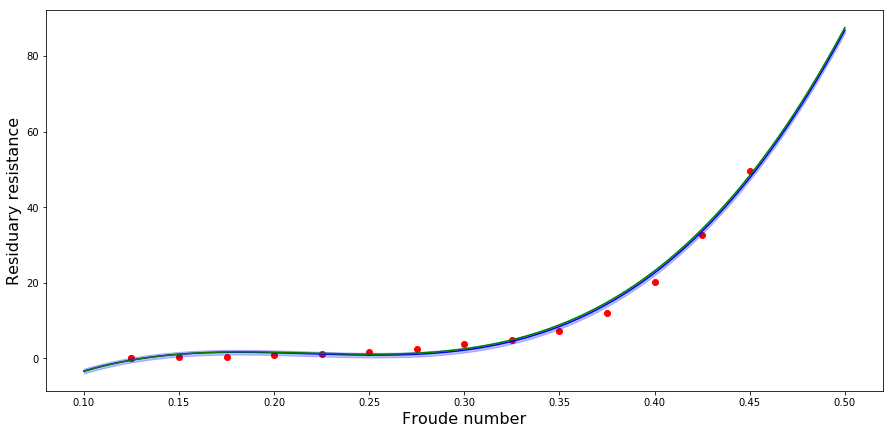

In [353]:
LR = LinearRegression().fit(list(zip(train_data['Froude number'],
                                     train_data['Froude number']**2,
                                     train_data['Froude number']**3)), 
                            train_data['Residuary resistance'])
GPR = GaussianProcessRegression(exp_cov).fit(train_data[['Longitudinal position', 
                                                         'Prismatic coefficient', 
                                                         'Length-displacement ratio',
                                                         'Beam-draught ratio',
                                                         'Length-beam ratio',
                                                         'Froude number']].values, 
                        train_data['Residuary resistance'].values - \
                        LR.predict(list(zip(train_data['Froude number'],
                                            train_data['Froude number'] ** 2,
                                            train_data['Froude number'] ** 3))))

plt.figure(figsize=(15, 7))
plt.scatter(data.loc[:14]['Froude number'], data.loc[:14]['Residuary resistance'], color='red')

grid = np.linspace(0.1, 0.5, 1000)
row = data.loc[0]
times = list(zip(np.full(len(grid), row['Longitudinal position']), 
                 np.full(len(grid), row['Prismatic coefficient']),
                 np.full(len(grid), row['Length-displacement ratio']),
                 np.full(len(grid), row['Beam-draught ratio']),
                 np.full(len(grid), row['Length-beam ratio']),
                 grid))
predict, sigma = GPR.predict(times)
predict += LR.predict(list(zip(grid,
                               grid ** 2,
                               grid ** 3)))
plt.plot(grid, predict, color='blue')
plt.fill_between(grid, predict + 2 * sigma, predict - 2 * sigma, 
                 color='blue', alpha=0.25)

plt.plot(grid, LR.predict(list(zip(grid, grid**2, grid**3))), color='green')

plt.xlabel('Froude number', fontsize=16)
plt.ylabel('Residuary resistance', fontsize=16)
plt.show()

In [360]:
lr_predict = LR.predict(list(zip(test_data['Froude number'],
                                 test_data['Froude number'] ** 2,
                                 test_data['Froude number'] ** 3)))
grp_predict, sigma = GPR.predict(test_data[['Longitudinal position', 
                                            'Prismatic coefficient', 
                                            'Length-displacement ratio',
                                            'Beam-draught ratio',
                                            'Length-beam ratio',
                                            'Froude number']].values) + lr_predict
print("Linear Regression error:",
      mean_squared_error(test_data['Residuary resistance'], lr_predict))
print("Gaussian Process Regression error:", 
      mean_squared_error(test_data['Residuary resistance'], grp_predict))

Linear Regression error: 6.15444989766
Gaussian Process Regression error: 5.45109354743


Ошибка получилась меньше

Дополнительно вы можете попробовать <a href="http://scikit-learn.org/stable/modules/classes.html#module-sklearn.gaussian_process">реализацию</a> регрессии на гауссовских процессах в `sklearn`.